# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

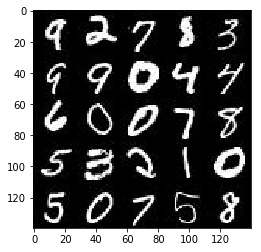

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

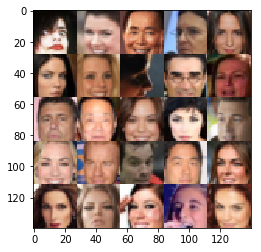

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0-rc2
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    i

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    depth1 = 32
    depth2 = 2*depth1
    depth3 = 2*depth2
    
    def leaky_relu(inp):
            return tf.maximum(inp, inp*alpha)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, depth1, 5, strides=2, padding='same')
        l1 = leaky_relu(l1)
        
        l2 = tf.layers.conv2d(l1, depth2, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = leaky_relu(l2)
            
        l3 = tf.layers.conv2d(l2, depth3, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = leaky_relu(l3)
        
        flatten = tf.reshape(l3, [-1, 4*4*depth3])
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    depth1 = 512
    depth2 = depth1 // 2
    depth3 = depth2 // 2
    
    def leaky_relu(inp):
            return tf.maximum(inp, inp*alpha)
        
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*depth1)
        l1 = tf.reshape(l1, [-1, 7, 7, depth1])
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = leaky_relu(l1)
        # 7 x 7
        
        l2 = tf.layers.conv2d_transpose(l1, depth2, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = leaky_relu(l2)
        # 14 x 14
        
        l3 = tf.layers.conv2d_transpose(l2, depth3, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = leaky_relu(l3)
        # 28 x 28
        
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
        # 28 x 28 x out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, alpha=alpha)
    d_output_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            # using this smooth value (0.9) helps optimizing (see Review\ 1.pdf)
            labels=0.9*tf.ones_like(d_output_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_output_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                step += 1
                
                # taking images from [-0.5, 0.5] range to [-1.0, 1.0] range
                batch_images = batch_images*2
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                feed = {real_input: batch_images, z: batch_z, lr: learning_rate}
                sess.run(d_train_opt, feed_dict=feed)
                sess.run(g_train_opt, feed_dict=feed)
                
                # print information every _ steps
                if step % print_every == 0:
                    train_loss_d = d_loss.eval(feed)
                    train_loss_g = g_loss.eval(feed)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show generated image samples every _ steps
                if step % show_every == 0:
#                     gen_samples = sess.run(generator(z, data_shape[3], is_train=False), feed_dict=feed)
#                     samples.append(gen_samples)
#                     pyplot.imshow(helper.images_square_grid(gen_samples, data_image_mode)) # cmap='gray')
                    show_generator_output(sess, 4, z, data_shape[3], data_image_mode)
                    
#         saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1025... Generator Loss: 0.0361
Epoch 1/1... Discriminator Loss: 3.6194... Generator Loss: 0.0669
Epoch 1/1... Discriminator Loss: 2.7204... Generator Loss: 0.2236
Epoch 1/1... Discriminator Loss: 2.3269... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 2.4951... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 2.0278... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.7082... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.9939... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.6404


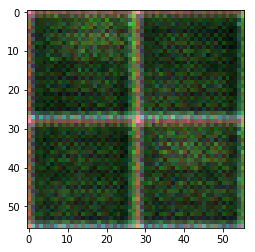

Epoch 1/1... Discriminator Loss: 1.8317... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.7916... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.8873... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.7696... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.7366... Generator Loss: 0.6247


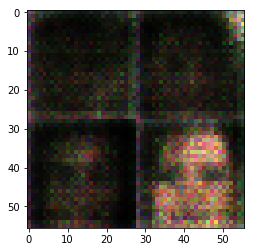

Epoch 1/1... Discriminator Loss: 1.7251... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.6998


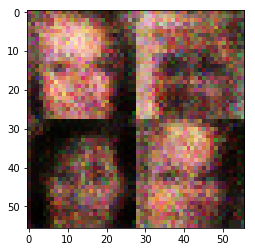

Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.7402


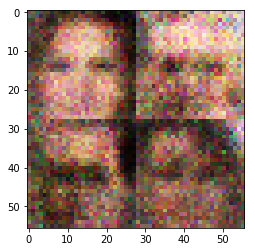

Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7339


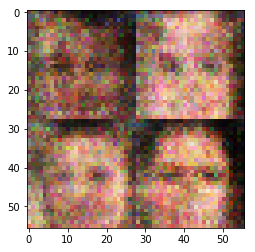

Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7644


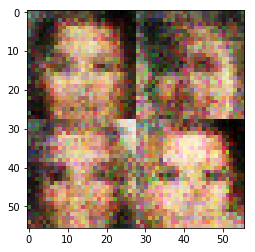

Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7417


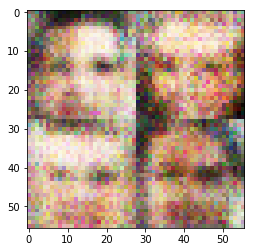

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7548


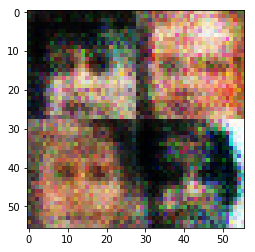

Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7814


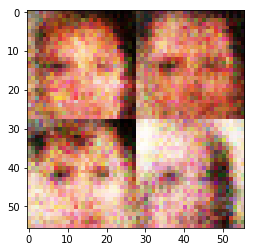

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8677


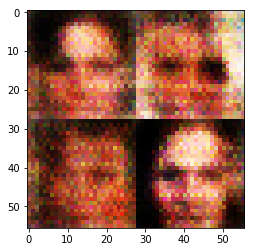

Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.8995
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 2.7485
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.0693


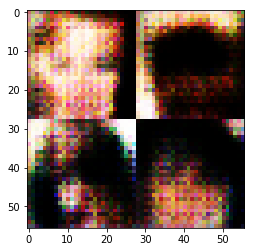

Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 2.7568
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 3.8294
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 2.1808
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.7839


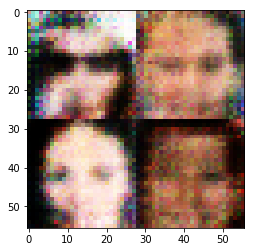

Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.7443... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.7244


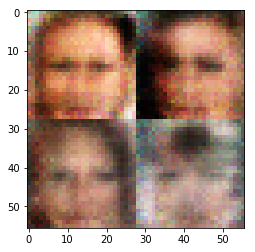

Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7625


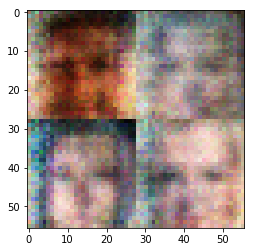

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7651


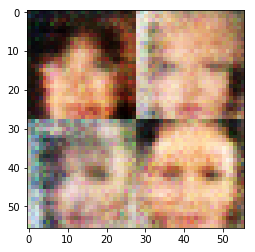

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7932


In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.